# Age and gender prediction

In this recipe, you will learn how to predict a person's age and gender by an image. One of the possible applications is collecting statistical information about people viewing content in digital signage displays for example.

We used two different models: one for gender classification and one for age group classification. Note that in this recipe, in contrast with the others, we subtract per-pixel mean values from the source image, not per-channel values. You can actually visualize the mean values and see the average human face.


In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2,start_3=0, end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S05\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s05\env

d:\html_doc\program\opencv\packt\s05\env\lib\site-packages
d:\html_doc\program\opencv\packt\s05\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s05\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s05\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s05\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s05\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S05\env


In [2]:
age_model = cv2.dnn.readNetFromCaffe('../data/age_gender/age_net_deploy.prototxt',
                                     '../data/age_gender/age_net.caffemodel')
gender_model = cv2.dnn.readNetFromCaffe('../data/age_gender/gender_net_deploy.prototxt',
                                        '../data/age_gender/gender_net.caffemodel')


#######################################################
if not age_model.empty():
    print('age_model Net loaded successfully')
print('Net contains:')
for t in age_model.getLayerTypes():
    print('\t%d layers of type %s' % (age_model.getLayersCount(t), t))

if not gender_model.empty():
    print('gender_model Net loaded successfully')
print('Net contains:')
for t in gender_model.getLayerTypes():
    print('\t%d layers of type %s' % (gender_model.getLayersCount(t), t))

age_model Net loaded successfully
Net contains:
	3 layers of type Convolution
	2 layers of type Dropout
	3 layers of type InnerProduct
	2 layers of type LRN
	3 layers of type Pooling
	5 layers of type ReLU
	1 layers of type Softmax
	1 layers of type __NetInputLayer__
gender_model Net loaded successfully
Net contains:
	3 layers of type Convolution
	2 layers of type Dropout
	3 layers of type InnerProduct
	2 layers of type LRN
	3 layers of type Pooling
	5 layers of type ReLU
	1 layers of type Softmax
	1 layers of type __NetInputLayer__


(1, 3, 256, 256) float64
------  mean_blob[0]-------------    Shape(3, 256, 256) mean_blob[0]: float64
[[89.4943161  89.58824158 89.46308899 89.5161438  89.52391052] [89.53952789 89.57320404 89.46333313 89.44208527 89.31652069] [89.43128967 89.5686264  89.58799744 89.50315094 89.31586456] ]
[[99.7124176  99.72672272 99.67227936 99.7747879  99.75950623] [99.78337097 99.73906708 99.67881775 99.69762421 99.52668762] [99.70432281 99.75328827 99.81230927 99.75484467 99.52031708] ]
[[112.6003418  112.65151978 112.50322723 112.56600952 112.61882019] [112.72132874 112.68347931 112.54148865 112.55628204 112.44576263] [112.66059113 112.72157288 112.7259903  112.67023468 112.50527191] ]
------  mean_blob_transpose------    Shape(256, 256, 3) mean_blob_transpose: float64
[[70.85204315 79.31112671 99.32723236] [71.21090698 79.63189697 99.35134125] [71.36418152 79.81884766 99.264534  ] [71.59674835 80.02427673 99.16169739] [71.83299255 80.22226715 99.11019135] [72.11199188 80.51810455 99.17493439] [

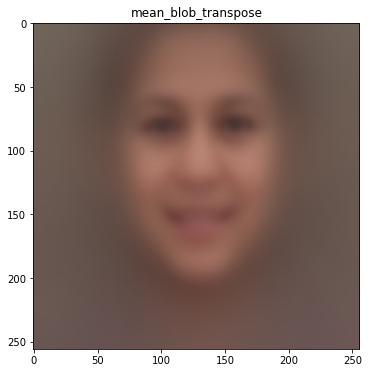

In [3]:
mean_blob = np.load('../data/age_gender/mean.npy')



##########################################
print(mean_blob.shape, mean_blob.dtype)
print_image('mean_blob[0]','mean_blob[0]',mean_blob[0],0,3,0,3)
mean_blob_transpose = np.transpose(mean_blob[0],(1,2,0))
print_image('mean_blob_transpose','mean_blob_transpose',mean_blob_transpose,0,3,180,187)
print_image('mean_blob_transpose','mean_blob_transpose',mean_blob_transpose.astype(np.uint8),0,3,180,187)
plt_view_image(plt,[["mean_blob_transpose",mean_blob_transpose.astype(np.uint8)[:,:,[2,1,0]]] ],
               figsize=(15,6),axis='on',cmap='gray')

------  orig_f[0:3,274:281]------    Shape(700, 1050, 3) orig_f: uint8
[[247 251 252] [249 253 254] [246 250 255] [234 242 249] [214 227 235] [196 216 227] [176 206 217] ]
[[247 251 252] [247 250 254] [243 247 252] [229 237 244] [209 221 231] [190 210 221] [165 194 208] ]
[[246 250 251] [245 248 252] [240 244 249] [222 232 239] [201 216 225] [181 203 214] [152 181 195] ]
------  orig_frame[0:3,99:106]---    Shape(700, 700, 3) orig_frame: uint8
[[247 251 252] [249 253 254] [246 250 255] [234 242 249] [214 227 235] [196 216 227] [176 206 217] ]
[[247 251 252] [247 250 254] [243 247 252] [229 237 244] [209 221 231] [190 210 221] [165 194 208] ]
[[246 250 251] [245 248 252] [240 244 249] [222 232 239] [201 216 225] [181 203 214] [152 181 195] ]


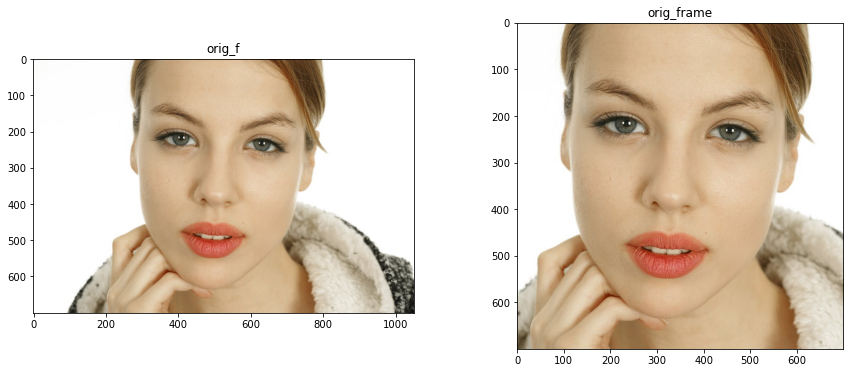

In [4]:
orig_f = cv2.imread('../data/face.jpeg')
dx = (orig_f.shape[1]-orig_f.shape[0]) // 2
orig_frame = np.copy(orig_f)
orig_frame = orig_frame[:,dx:dx+orig_frame.shape[0]]


####################################################
print_image('orig_f[0:3,274:281]','orig_f',orig_f,0,3,274,281)
print_image('orig_frame[0:3,99:106]','orig_frame',orig_frame,0,3,99,106)
plt_view_image(plt,[["orig_f",orig_f[:,:,[2,1,0]]],
                    ["orig_frame",orig_frame[:,:,[2,1,0]]],
                   ],
               figsize=(15,6),axis='on',cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------  orig_f[0:3,274:281]------    Shape(700, 1050, 3) orig_f: uint8
[[247 251 252] [249 253 254] [246 250 255] [234 242 249] [214 227 235] [196 216 227] ]
[[247 251 252] [247 250 254] [243 247 252] [229 237 244] [209 221 231] [190 210 221] ]
[[246 250 251] [245 248 252] [240 244 249] [222 232 239] [201 216 225] [181 203 214] ]
------  orig_frame[0:3,99:106]---    Shape(700, 700, 3) orig_frame: uint8
[[247 251 252] [249 253 254] [246 250 255] [234 242 249] [214 227 235] [196 216 227] ]
[[247 251 252] [247 250 254] [243 247 252] [229 237 244] [209 221 231] [190 210 221] ]
[[246 250 251] [245 248 252] [240 244 249] [222 232 239] [201 216 225] [181 203 214] ]

frame0.shape[1]/orig_frame.shape[1] = 0.3657142857142857 <class 'float'>
dy(99)= 36 dy(106) = 38
------  frame0 [0:3,36:41]-------    Shape(256, 256, 3) frame0: float32
[[247. 251. 253.] [229. 237. 244.] [172. 199. 212.] [105. 146. 165.] [ 80. 120. 144.] ]
[[243. 248. 250.] [219. 230. 238.] [153. 182. 196.] [ 95. 135. 156.] [ 81. 

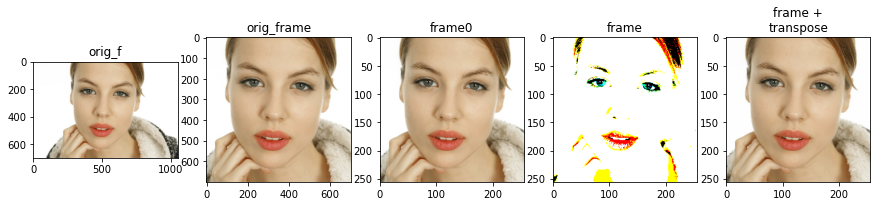

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


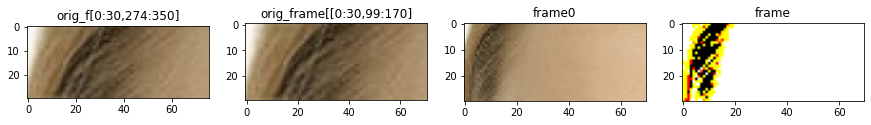

In [5]:
frame0 = cv2.resize(orig_frame, (256,256)).astype(np.float32)
frame = np.copy(frame0)
frame -= np.transpose(mean_blob[0], (1,2,0))


####################################################
print_image('orig_f[0:3,274:281]','orig_f',orig_f,0,3,274,280)
print_image('orig_frame[0:3,99:106]','orig_frame',orig_frame,0,3,99,105)

dy_frame = frame0.shape[1]/orig_frame.shape[1]
print("\nframe0.shape[1]/orig_frame.shape[1] =",dy_frame, type(dy_frame))

frame0_y0 = int(99*dy_frame); frame0_y1 = int(106*dy_frame)
print("dy(99)=",frame0_y0, "dy(106) =",frame0_y1 )
print_image('frame0 [0:3,36:41]','frame0',frame0,0,3,frame0_y0,frame0_y1+3)

print_image('mean_blob_transpose[0:3,36:41]','mean_blob_transpose',
            mean_blob_transpose.astype(np.uint8),0,3,36,42)
print_image('frame[0:3,36:41]','frame',frame.astype(np.uint8),0,3,36,42)

print_image('mean_blob_transpose[0:3,36:41]','mean_blob_transpose',
            mean_blob_transpose,0,3,36,41)
print_image('frame[0:3,36:41]','frame',frame,0,3,36,41)


plt_view_image(plt,[["orig_f",orig_f[:,:,[2,1,0]]],
                    ["orig_frame",orig_frame[:,:,[2,1,0]]],
                    ["frame0",frame0.astype(np.uint8)[:,:,[2,1,0]]],
                    ["frame",frame[:,:,[2,1,0]]],
                    ["frame +\ntranspose",
                     (frame.astype(np.uint8)+mean_blob_transpose.astype(np.uint8))[:,:,[2,1,0]]],
                   ],
               figsize=(15,6),axis='on',cmap='gray')
plt_view_image(plt,[["orig_f[0:30,274:350]",orig_f[0:30,274:350,[2,1,0]]],
                    ["orig_frame[[0:30,99:170]",orig_frame[0:30,99:170,[2,1,0]]],
                    ["frame0",frame0.astype(np.uint8)[0:30,36:106,[2,1,0]]],
                    ["frame",frame[0:30,36:106,[2,1,0]]],
                   ],
               figsize=(15,6),axis='on',cmap='gray')

In [ ]:
blob = cv2.dnn.blobFromImage(frame, 1, (256,256))


##########################################
print(blob.shape, blob.dtype)
print_image('blob[0]','blob[0]',blob[0],0,3,0,3,0,7)
blob_transpose = np.transpose(blob[0],(1,2,0))
print_image('blob_transpose','blob_transpose',blob_transpose,0,3,36,41)
print_image('blob_transpose','blob_transpose',blob_transpose.astype(np.uint8),0,3,36,42)

print_image('frame[0:3,36:41]','frame',frame.astype(np.uint8),0,3,36,42)

plt_view_image(plt,[["blob_transpose",blob_transpose.astype(np.uint8)[:,:,[2,1,0]]],
                    ['frame[0:3,36:41]',frame.astype(np.uint8)[:,:,[2,1,0]]]
                   ],
               figsize=(15,6),axis='on',cmap='gray')

In [ ]:
GENDER_LIST = ['male','female']

gender_model.setInput(blob)
gender_prob = gender_model.forward()
gender_id = np.argmax(gender_prob)



###################################
print(gender_prob)
print('Gender: {0} with prob: {1}'.format(GENDER_LIST[gender_id], gender_prob[0, gender_id]))

In [ ]:
AGE_LIST = ['(0, 2)','(4, 6)','(8, 12)','(15, 20)', '(25, 32)','(38, 43)','(48, 53)','(60, 100)']

age_model.setInput(blob)
age_prob = age_model.forward()
age_id = np.argmax(age_prob)



###################################
print(age_prob)
print('Age group: {} with prob: {}'.format(AGE_LIST[age_id], age_prob[0, age_id]))

In [ ]:
plt_view_image(plt,[["orig_f",orig_f[:,:,[2,1,0]]],
                    ["orig_frame",orig_frame[:,:,[2,1,0]]],
                    ["frame0",frame0.astype(np.uint8)[:,:,[2,1,0]]],
                    ["frame +\ntranspose",
                     (frame.astype(np.uint8)+mean_blob_transpose.astype(np.uint8))[:,:,[2,1,0]]],
                   ],
               figsize=(15,6),axis='on',cmap='gray')